# Pytorch for Beginners

lets explore what pytorch offers

lots of this notebook is borrowed from jeremy howards great tutorial! https://pytorch.org/tutorials/beginner/nn_tutorial.html

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np

from pathlib import Path
import requests
import pickle
import gzip

In [53]:
a = np.array([1.0,1.0,1.0,1.0])
a, np.exp(a)

(array([[1.],
        [1.],
        [1.],
        [1.]]), array([[2.71828183],
        [2.71828183],
        [2.71828183],
        [2.71828183]]))

In [55]:
a = torch.tensor([1.0,1.0,1.0,1.0])
a, a.exp()

(tensor([1., 1., 1., 1.]), tensor([2.7183, 2.7183, 2.7183, 2.7183]))

In [7]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"
FILENAME = "mnist.pkl.gz"

## MNIST data

### download the data

In [18]:
PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

### unzip data

we have downloaded the gzipped pickle now we need to unzip it and load it into python

In [8]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [9]:
x_train.shape, y_train.shape

((50000, 784), (50000,))

### look at data

In [10]:
x_train[0].shape

(784,)

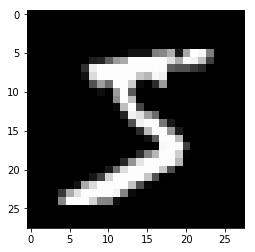

In [11]:
img = x_train[0].reshape(28, 28)

plt.imshow(img, cmap="gray")

### convert our numpy arrays into torch tensors 

In [12]:
import torch

In [13]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

In [14]:
# get our sample size m and input size n
m, n = x_train.shape

print('Full dataset X shape: ',x_train.shape)
print('The classes of number: ',y_train.min(), y_train.max())

print(x_train, y_train)

Full dataset X shape:  torch.Size([50000, 784])
The classes of number:  tensor(0) tensor(9)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])


## Logistic regression from scratch 

basically a neural net with no hidden layers. A linear transformation and a activation function

like the equation for a line:

$ y = ax + b $

expect our input is not just 1 number, its a vector x
in our case its a vector of length 784

$ x = \begin{bmatrix} 1 \\ 2 \\ \vdots \\ 784 \end{bmatrix} $

so now we have

$ \hat{y} = wx + b   $

where w and x are vectors of length 784 and b is scalar ( just a number )

In [33]:
input_d, output_d = 784, 10

weights = torch.randn(input_d, output_d)
weights.requires_grad_() # mutates weights tensor to use grads

bias = torch.zeros(output_d, requires_grad=True)

In [34]:
# we can check out tensors for grad
weights.requires_grad, bias.requires_grad

(True, True)

You can define function vectorized or GPU calculation like you can in numpy.



In [35]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

In [36]:
## our model can be written simply as the basic calculations of
# 

def model(x_batch):
    a = x_batch @ weights + bias
    return log_softmax(a)

### forward pass

predict for a minibatch of data

In [37]:
bs = 64

# grab a minibatch and perform a forward pass 
# xb = batch of x
xb = x_train[0:bs]
preds = model(xb)

preds[0], preds.shape

(tensor([-1.1668e+01, -2.4357e+01, -3.6294e+01, -8.2376e+00, -2.0591e+01,
         -9.2697e-04, -7.3537e+00, -1.1239e+01, -2.6452e+01, -2.1156e+01],
        grad_fn=<SelectBackward>), torch.Size([64, 10]))

### loss function

we need loss function before we can calculate our gradient

In [56]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [57]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(12.6650, grad_fn=<NegBackward>)


### accuracy metric

we should also use accurarcy metric to tell us how often our model is correct

In [58]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [59]:
print(accuracy(preds, yb))

tensor(0.1250)


### Training loop

now we can get to gradient descent

What we need to descent the gradient
- model
- loss
- backward propagation 
- update our models weights

In [60]:
# from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    print('epoch: ',epoch)
    for i in range((m - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        
        if i % 100 == 0:
            print('our loss:, ', loss)
            
        # Pytorch protect updates to weights because otherwise these calculations should be part of the computation graph!
        # so we need to tell pytorch that we dont care about the following changes being tracked in .grad
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

epoch:  0
our loss:,  tensor(0.3419, grad_fn=<NegBackward>)
our loss:,  tensor(0.3509, grad_fn=<NegBackward>)
our loss:,  tensor(0.2819, grad_fn=<NegBackward>)
our loss:,  tensor(0.4068, grad_fn=<NegBackward>)
our loss:,  tensor(0.3016, grad_fn=<NegBackward>)
our loss:,  tensor(0.6158, grad_fn=<NegBackward>)
our loss:,  tensor(0.2643, grad_fn=<NegBackward>)
our loss:,  tensor(0.6440, grad_fn=<NegBackward>)
epoch:  1
our loss:,  tensor(0.2650, grad_fn=<NegBackward>)
our loss:,  tensor(0.3182, grad_fn=<NegBackward>)
our loss:,  tensor(0.2335, grad_fn=<NegBackward>)
our loss:,  tensor(0.3850, grad_fn=<NegBackward>)
our loss:,  tensor(0.2683, grad_fn=<NegBackward>)
our loss:,  tensor(0.5611, grad_fn=<NegBackward>)
our loss:,  tensor(0.2433, grad_fn=<NegBackward>)
our loss:,  tensor(0.5902, grad_fn=<NegBackward>)


In [30]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.5727, grad_fn=<NegBackward>) tensor(0.8281)


# Refactor with 
# nn.Module, nn.Linear, nn.Functional 

Heaps of commonly used loss functions and NN layer patterns are already implemented in PyTorch

In [193]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [133]:
import torch.nn.functional as F

loss_func = F.cross_entropy

In [134]:
model = Mnist_Logistic()

In [135]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(2.3288, grad_fn=<NllLossBackward>) tensor(0.)


### with model.parameters() 
Before we had to update every weight by name, now we can retreive them all with the model.parameters() method

In [88]:

def fit(epochs):
    for epoch in range(epochs):
        print(epoch)
        for i in range((m - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            if i % 100 == 0:
                print('our loss:, ', loss)
                
            loss.backward()
            with torch.no_grad():
                #re write to use model.parameters()
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

In [89]:
fit(1)

0
our loss:,  tensor(2.3400, grad_fn=<NllLossBackward>)
our loss:,  tensor(0.3126, grad_fn=<NllLossBackward>)
our loss:,  tensor(0.3004, grad_fn=<NllLossBackward>)
our loss:,  tensor(0.3911, grad_fn=<NllLossBackward>)
our loss:,  tensor(0.2335, grad_fn=<NllLossBackward>)
our loss:,  tensor(0.3862, grad_fn=<NllLossBackward>)
our loss:,  tensor(0.2601, grad_fn=<NllLossBackward>)
our loss:,  tensor(0.3791, grad_fn=<NllLossBackward>)


In [90]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1110, grad_fn=<NllLossBackward>) tensor(1.)


### Now use Optim

In [91]:
from torch import optim

In [194]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [195]:
model, opt = get_model()
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(2.3455, grad_fn=<NllLossBackward>) tensor(0.1250)


In [97]:
def fit(epochs, model, opt, loss_func):
    for epoch in range(epochs):
        print(epoch)
        for i in range((m - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            if i % 100 == 0:
                print('our loss:, ', loss)
            
            # our optimizer 
            loss.backward()
            opt.step()
            opt.zero_grad()

In [98]:
fit(1, model, opt, loss_func)

0
our loss:,  tensor(0.2758, grad_fn=<NllLossBackward>)
our loss:,  tensor(0.2622, grad_fn=<NllLossBackward>)
our loss:,  tensor(0.1931, grad_fn=<NllLossBackward>)
our loss:,  tensor(0.3439, grad_fn=<NllLossBackward>)
our loss:,  tensor(0.2108, grad_fn=<NllLossBackward>)
our loss:,  tensor(0.3546, grad_fn=<NllLossBackward>)
our loss:,  tensor(0.2273, grad_fn=<NllLossBackward>)
our loss:,  tensor(0.3586, grad_fn=<NllLossBackward>)


## PyTorch Datasets

abstract class where you need to implement

__len__ & __getitem__ methods 

## PyTorch Dataloader

manages getting batches for our training loop from our dataloader

returns a python interator

In [109]:
from torch.utils.data import TensorDataset, DataLoader

In [110]:
TensorDataset??

In [111]:
train_ds = TensorDataset(x_train, y_train)

In [112]:
x, y = train_ds[0]
x.shape, y

(torch.Size([784]), tensor(5))

In [119]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

In [121]:
for xb, yb in train_dl:
    print(xb.shape)

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

### train and validation Dataloaders

In [268]:
def get_data(x_train, y_train, bs):
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

    valid_ds = TensorDataset(x_valid, y_valid)
    valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
    return train_dl, valid_dl

train_dl, valid_dl = get_data(x_train, y_train, 64)

In [196]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    y_pred = model(xb)
    loss = loss_func(y_pred, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb), y_pred, yb

In [197]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums, preds, ys = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        validation_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        
        accs = [ accuracy(yhat, y).item() for yhat, y in zip(preds, ys)]
        
        print(epoch, validation_loss, np.sum(accs)/ len(accs))

combine it all together

In [199]:
model, opt = get_model()
fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.30248018956184386 0.9149525316455697
1 0.3148197050571442 0.9100079113924051
2 0.3267840696334839 0.9056566455696202
3 0.27755440430641176 0.9240506329113924
4 0.29774869232177736 0.9154469936708861


###  CNN

In [218]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
#         print(self.training)
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.adaptive_avg_pool2d(xb, 1)
        return xb.view(-1, xb.size(1))
        
        
        

In [244]:
Mnist_CNN()

Mnist_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)

In [219]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

fit(3, model, loss_func, opt, train_dl, valid_dl)

0 1.2702548347473144 0.5892998417721519
1 0.6664396021842957 0.7948971518987342
2 0.43367488927841186 0.8750988924050633


In [216]:
fit(3, model, loss_func, opt, train_dl, valid_dl)

0 0.22429709463119507 0.9354232594936709
1 0.2050009204864502 0.9424446202531646
2 0.2072999261856079 0.9428401898734177


In [214]:
F.adaptive_avg_pool2d??

### nn.Sequential

In [221]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
)

In [227]:
xb, yb = next(iter(train_dl))

In [228]:
model(xb)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [16, 1, 3, 3], but got 2-dimensional input of size [64, 784] instead

In [264]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [265]:
model = nn.Sequential(
    Lambda(lambda xb: xb.view(-1, 1, 28, 28)),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda xb: xb.view(-1, xb.size(1)))
)

In [266]:
opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

fit(3, model, loss_func, opt, train_dl, valid_dl)

0 1.3496015674591064 0.5609177215189873
1 0.6757259038925171 0.7830300632911392
2 0.44800182189941407 0.8636273734177216


# GPU!

In [234]:
torch.cuda.is_available()

False

In [235]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [236]:
dev

device(type='cpu')

### We need all our tensor ops to be on the GPU 

Otherwise we will get an error 

This means we have to put our dataset onto the gpu as well as our model

In [259]:
def to_device(x, y):
    return x.to(dev), y.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [269]:
train_dl, valid_dl = get_data(x_train, y_train, 64)
train_dl = WrappedDataLoader(train_dl, to_device)
valid_dl = WrappedDataLoader(valid_dl, to_device)

In [270]:
model = model.to(dev)
opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [272]:
%%time
fit(10, model, loss_func, opt, train_dl, valid_dl)

0 0.20664597454071046 0.9376977848101266
1 0.2013221917152405 0.9416534810126582
2 0.199952001953125 0.9433346518987342
3 0.18992808513641357 0.9444224683544303
4 0.18371812086105346 0.9486748417721519
5 0.1758351182937622 0.9511471518987342
6 0.16914637775421143 0.9523338607594937
7 0.1881415760040283 0.9475870253164557
8 0.18738684339523315 0.9472903481012658
9 0.17089933853149414 0.9521360759493671
CPU times: user 55.7 s, sys: 1min 52s, total: 2min 47s
Wall time: 1min 24s
